In [1]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import os
import sklearn.preprocessing as prep
   
Comp = ['S2000001', 'S2000002', 'S2000003', 'S2000004']

namee1 = '/home/mabbasloo/Documents/carCrashData/f001_S2000001_1.mat' 
namee2 = '/home/mabbasloo/Documents/carCrashData/f001_S2000002_1.mat' 
namee3 = '/home/mabbasloo/Documents/carCrashData/f001_S2000003_1.mat'
namee4 = '/home/mabbasloo/Documents/carCrashData/f001_S2000004_1.mat'

namee = [namee1, namee2, namee3, namee4]

name1 = '/home/mabbasloo/Documents/carCrashData/S2000001/data/'
name2 = '/home/mabbasloo/Documents/carCrashData/S2000002/data/'
name3 = '/home/mabbasloo/Documents/carCrashData/S2000003/data/'
name4 = '/home/mabbasloo/Documents/carCrashData/S2000004/data/'

name = [name1, name2, name3, name4]

files = ['1', '2', '3', '4']
DIMM = [1714, 1736, 1519, 1705]
P = len(DIMM)
pol = [+1, -1, +1, +1]

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)

In [3]:
DATAall = []
dataall = []
st = 10
stride = 6
d = 40
for p in range(P):
    filename = '/home/mabbasloo/Documents/carCrashData/200000' + files[p]
    with open(filename) as f:
        data = f.readlines() 
    data = [x.strip() for x in data]   
    data = sorted(data, key=lambda x:x[0:4])[0::stride]
    dataall.append(data)
    DATA = []
    hm = len(data)
    dimm = DIMM[p]
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    for i in range(hm):
        db1 = h5py.File(name[p] + data[i], 'r')
        ds1 = db1['shape_xyz']
        ds1 = np.asarray(ds1).astype(np.float32)
        ds1[np.isnan(ds1)] = 0.0
        ds1[np.isinf(ds1)] = 0.0   
        if ds1.shape[1] == DIMM[p]:
            DATA.append(np.dot(ds1, ds))
        else:
            print (data[i])
    DATAall.append(DATA) 
print (len(DATAall), len(DATAall[0]), DATAall[0][0].shape) 

4 2050 (3, 40)


In [4]:
DATA = []
for i in range(len(DATAall[0])):
    dummy = np.zeros((3, d*P))
    for j in range(P):
        dummy[:, j*d:(j+1)*d] = DATAall[j][i]
    DATA.append(dummy)
DATA = np.asarray(DATA)            
print (len(DATAall), len(DATAall[0]), DATAall[0][0].shape) 

4 2050 (3, 40)


In [5]:
LX = []
LY = []
LZ = []
for p in range(P):
    lx = np.linalg.norm(np.asarray(DATA[0,:,p*d:(p+1)*d]))
    ly = np.linalg.norm(np.asarray(DATA[0,:,p*d:(p+1)*d]))
    lz = np.linalg.norm(np.asarray(DATA[0,:,p*d:(p+1)*d]))
    LX.append(lx)
    LY.append(ly)
    LZ.append(lz)    
    for i in range(hm):
        DATA[i,0,p*d:(p+1)*d] = pol[p]*DATA[i,0,p*d:(p+1)*d]/lx
        DATA[i,1,p*d:(p+1)*d] = pol[p]*DATA[i,1,p*d:(p+1)*d]/ly
        DATA[i,2,p*d:(p+1)*d] = pol[p]*DATA[i,2,p*d:(p+1)*d]/lz

print (LX, LY, LZ)   

[9738.455802987864, 10748.449957021954, 8525.812131722227, 10707.903183093353] [9738.455802987864, 10748.449957021954, 8525.812131722227, 10707.903183093353] [9738.455802987864, 10748.449957021954, 8525.812131722227, 10707.903183093353]


/home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


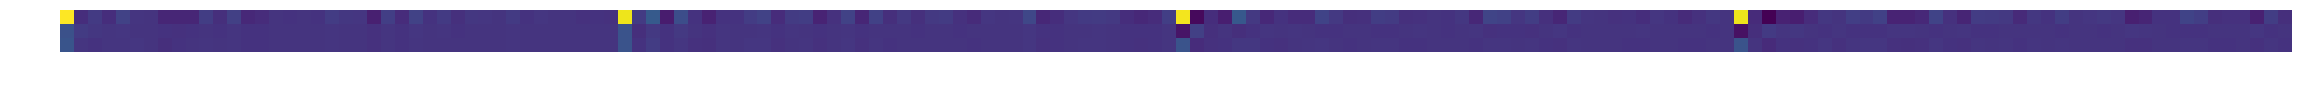

In [6]:
plt.figure(figsize=(d, d));
plt.axis('off')
plt.imshow(DATA[0])
#plt.figure(figsize=(10, 10));
#_,_,_ = plt.hist(DATA[0][:,0:d].reshape(3*d), bins=50)
#plt.figure(figsize=(10, 10));
#_,_,_ = plt.hist(DATA[0][:,d:2*d].reshape(3*d), bins=50)

In [7]:
dim = np.int(len(data)/st)
DATA3 = []
for i in range(dim):
    D = np.asarray(DATA[i*st:(i+1)*st]).reshape(st, 3, P*d)
    DATA3.append(D)
DATA3 = np.asarray(DATA3)    
print (DATA3.shape)  

(205, 10, 3, 160)


In [8]:
# lstm autoencoder reconstruct and predict sequence
from numpy import array
from keras.models import Model
from keras.layers import Input, concatenate, Add, Multiply
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model


# define input sequence
#[samples, timesteps, features]
seq_in = []
for j in range(dim):
    dummy = DATA3[j]
    for p in range(P):
        seq_in.append(dummy[:,:,p*d:(p+1)*d].reshape(st, 3*d))
seq_in = np.asarray(seq_in)
print (seq_in.shape)


n_in = seq_in.shape[1]

# prepare output sequence
l = np.int(st/2)
seq_out = seq_in[:, l:, :]
n_out = n_in - l

# define encoder
visible = Input(shape=(n_in, 3*d))
encoder = LSTM(1000, activation='relu')(visible)

# define reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(1500, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(3*d))(decoder1)

# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(2000, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(3*d))(decoder2)

# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

Using TensorFlow backend.


(820, 10, 120)


In [9]:
model.fit(seq_in, [seq_in,seq_out], epochs=20, verbose=0)

In [10]:
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)

print (len(yhat), yhat[0].shape)

2 (820, 10, 120)


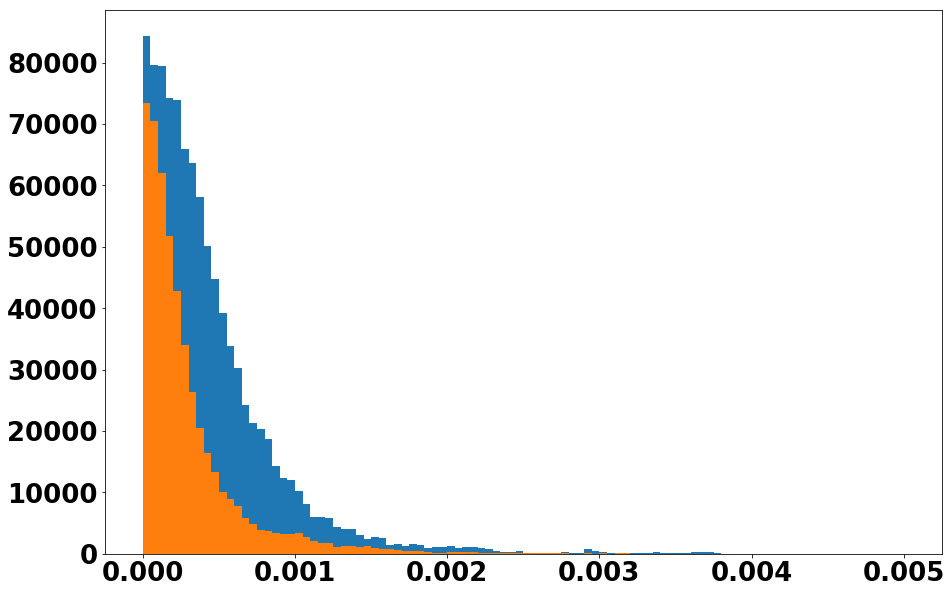

In [11]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
_,_,_ = ax.hist(np.abs(yhat[0] - seq_in).reshape(seq_in.shape[0]*seq_in.shape[1]*seq_in.shape[2]), bins=100, range=[0.0,0.005])
_,_,_ = ax.hist(np.abs(yhat[1] - seq_in[:, l:, :]).reshape(seq_in.shape[0]*(seq_in.shape[1]-l)*seq_in.shape[2]), bins=100, range=[0.0,0.005])

Text(0.5, 0, 'z')

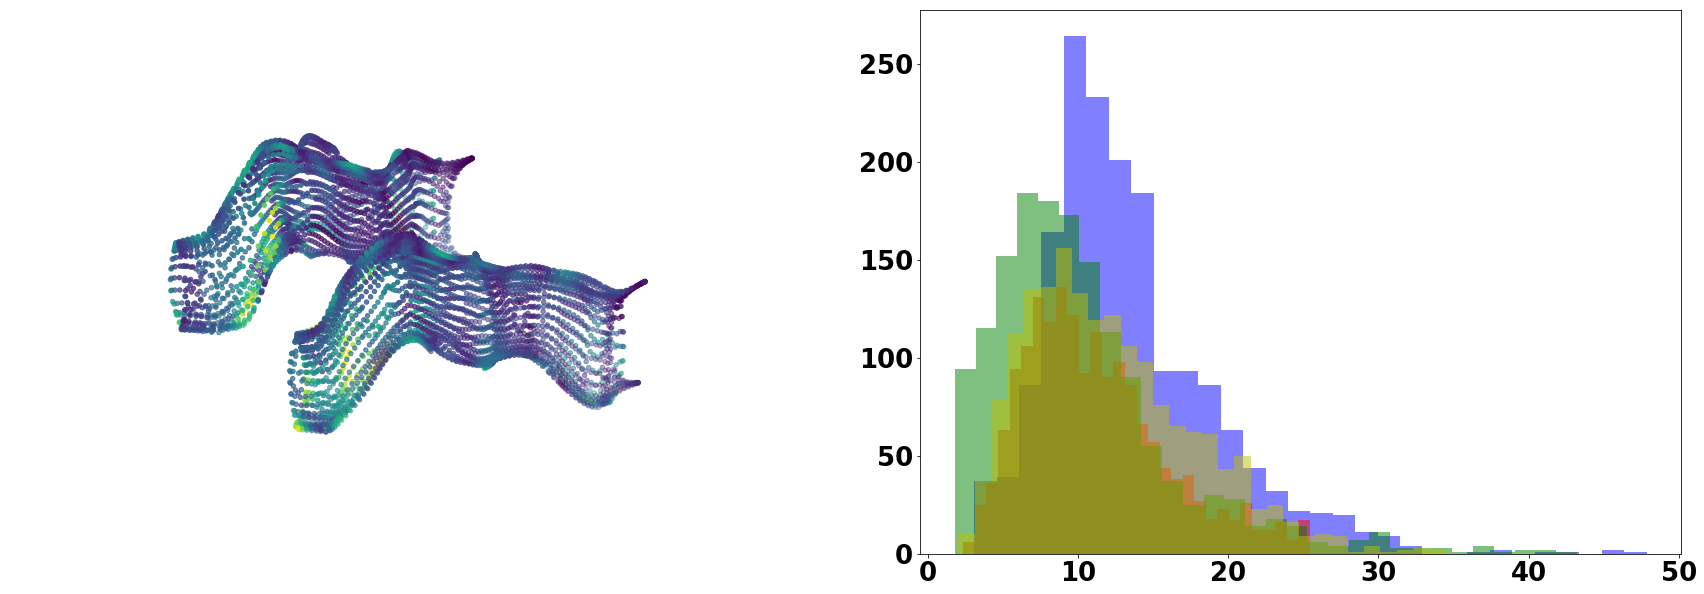

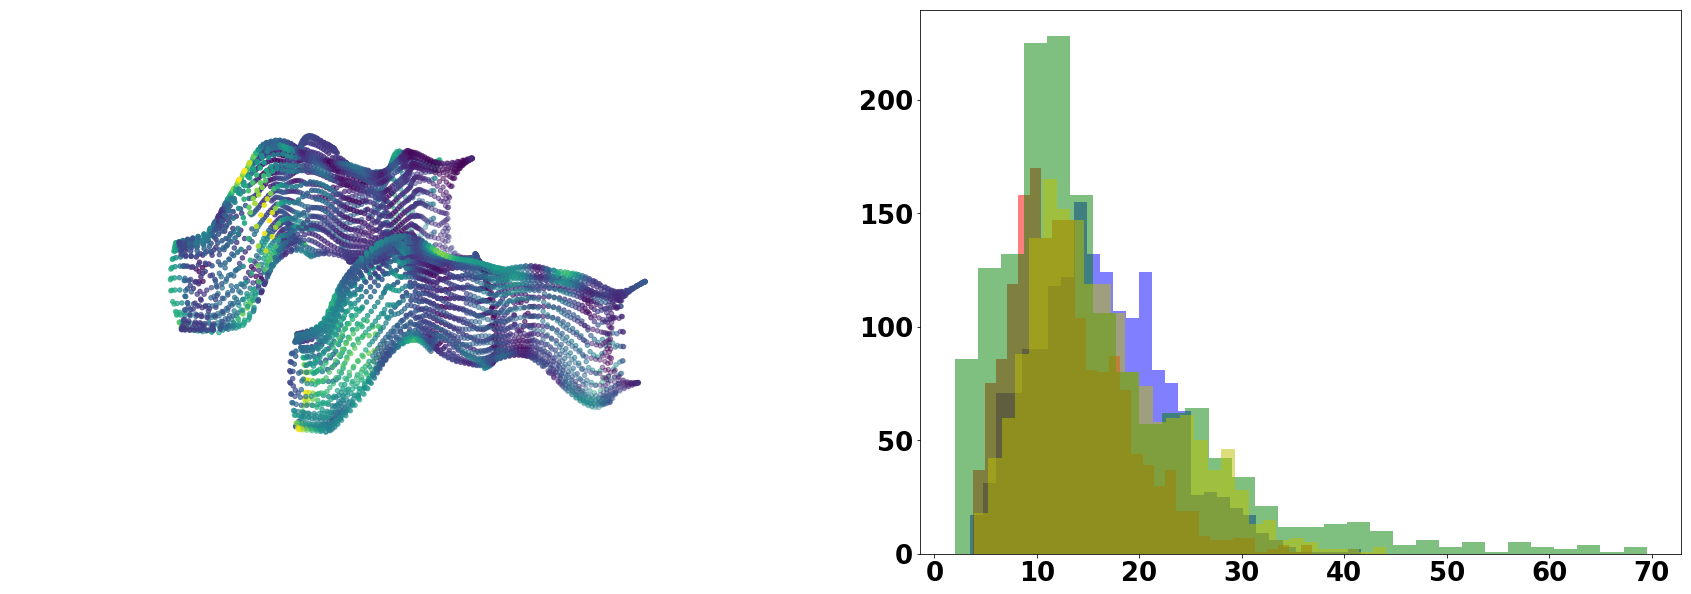

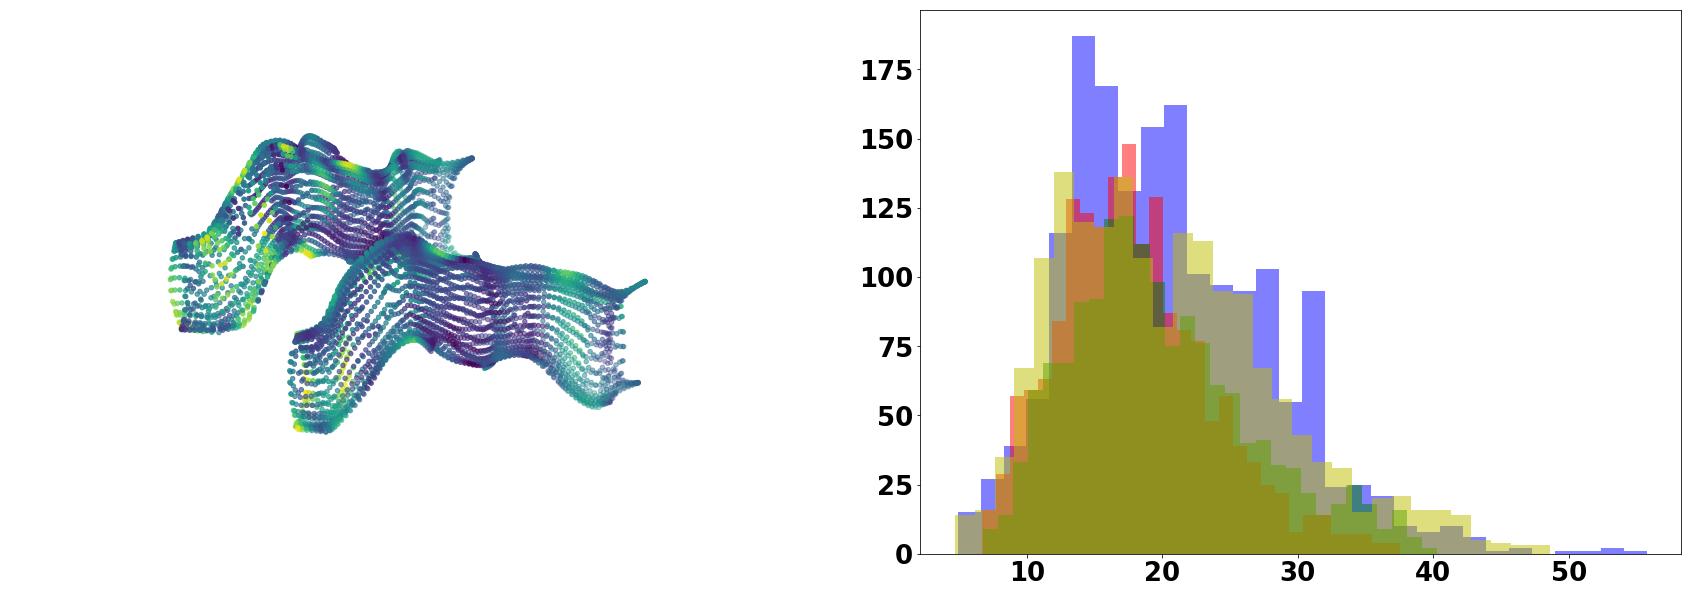

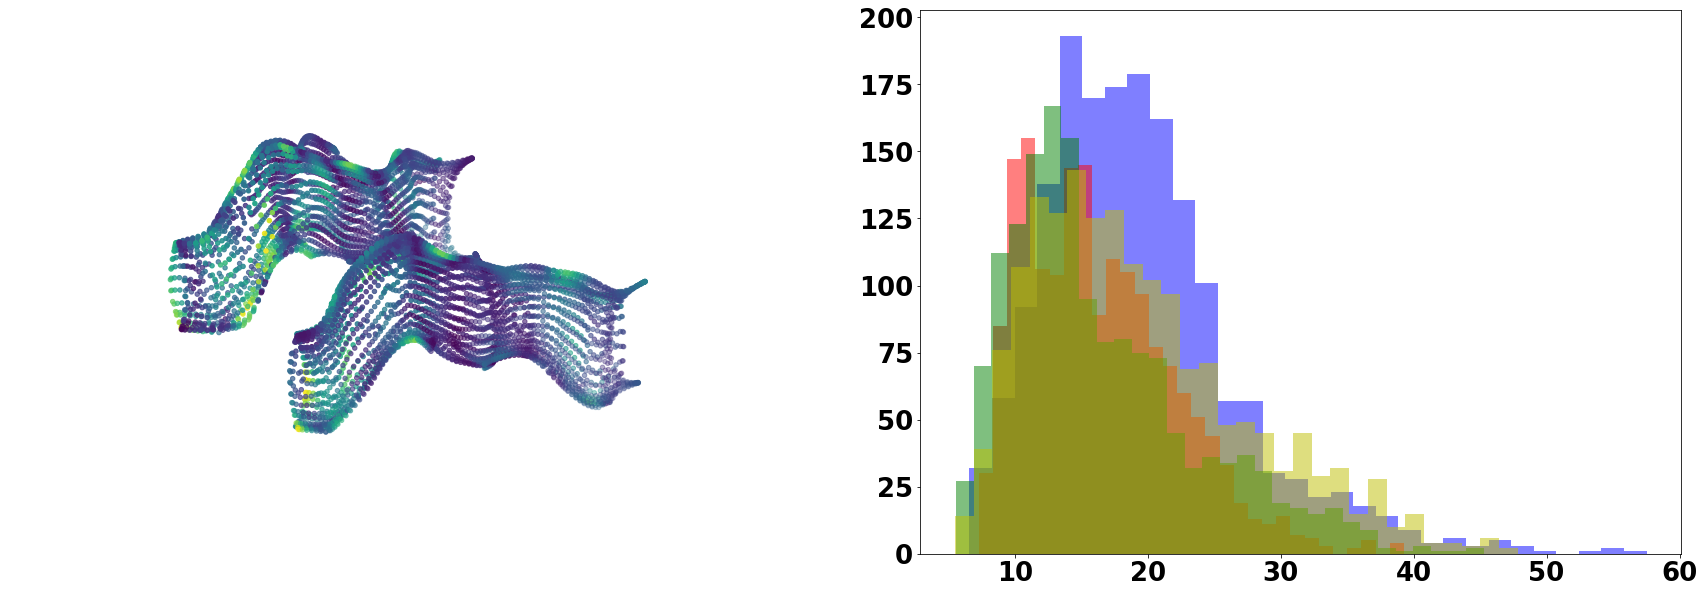

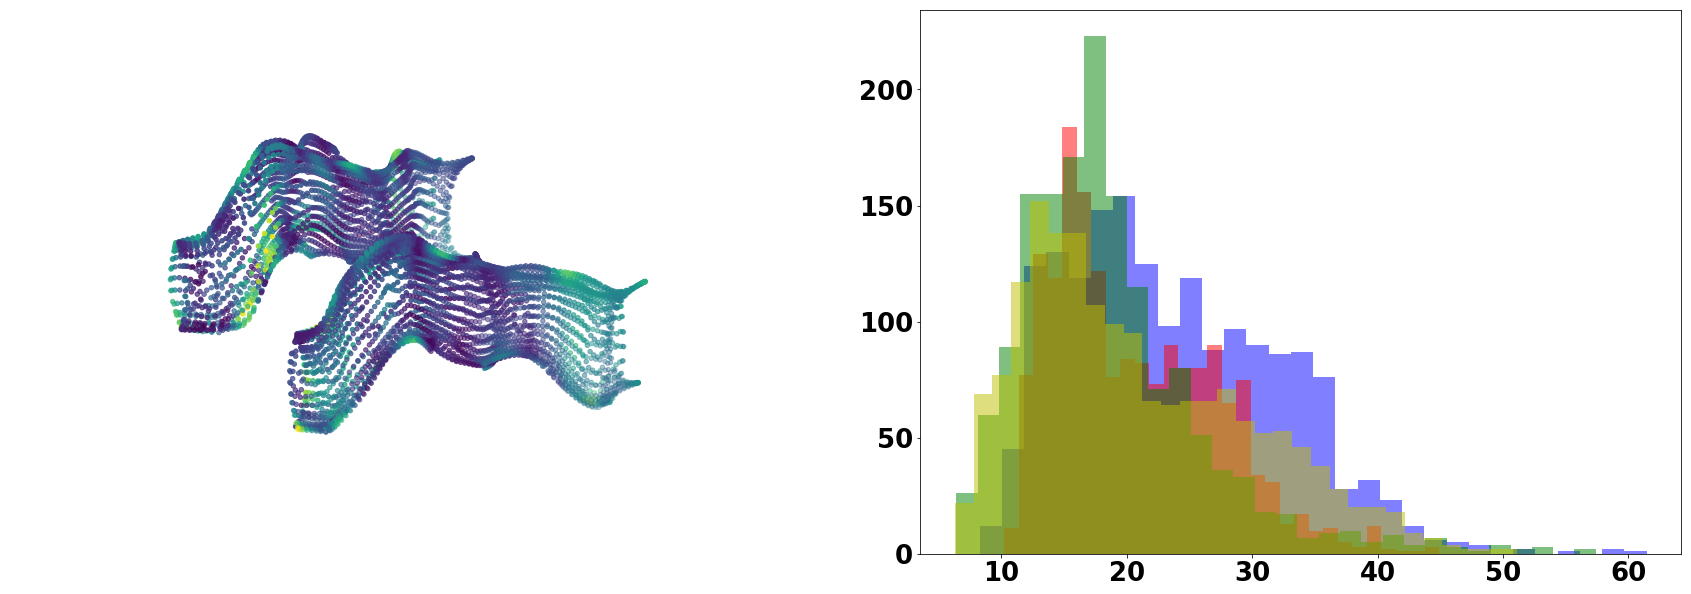

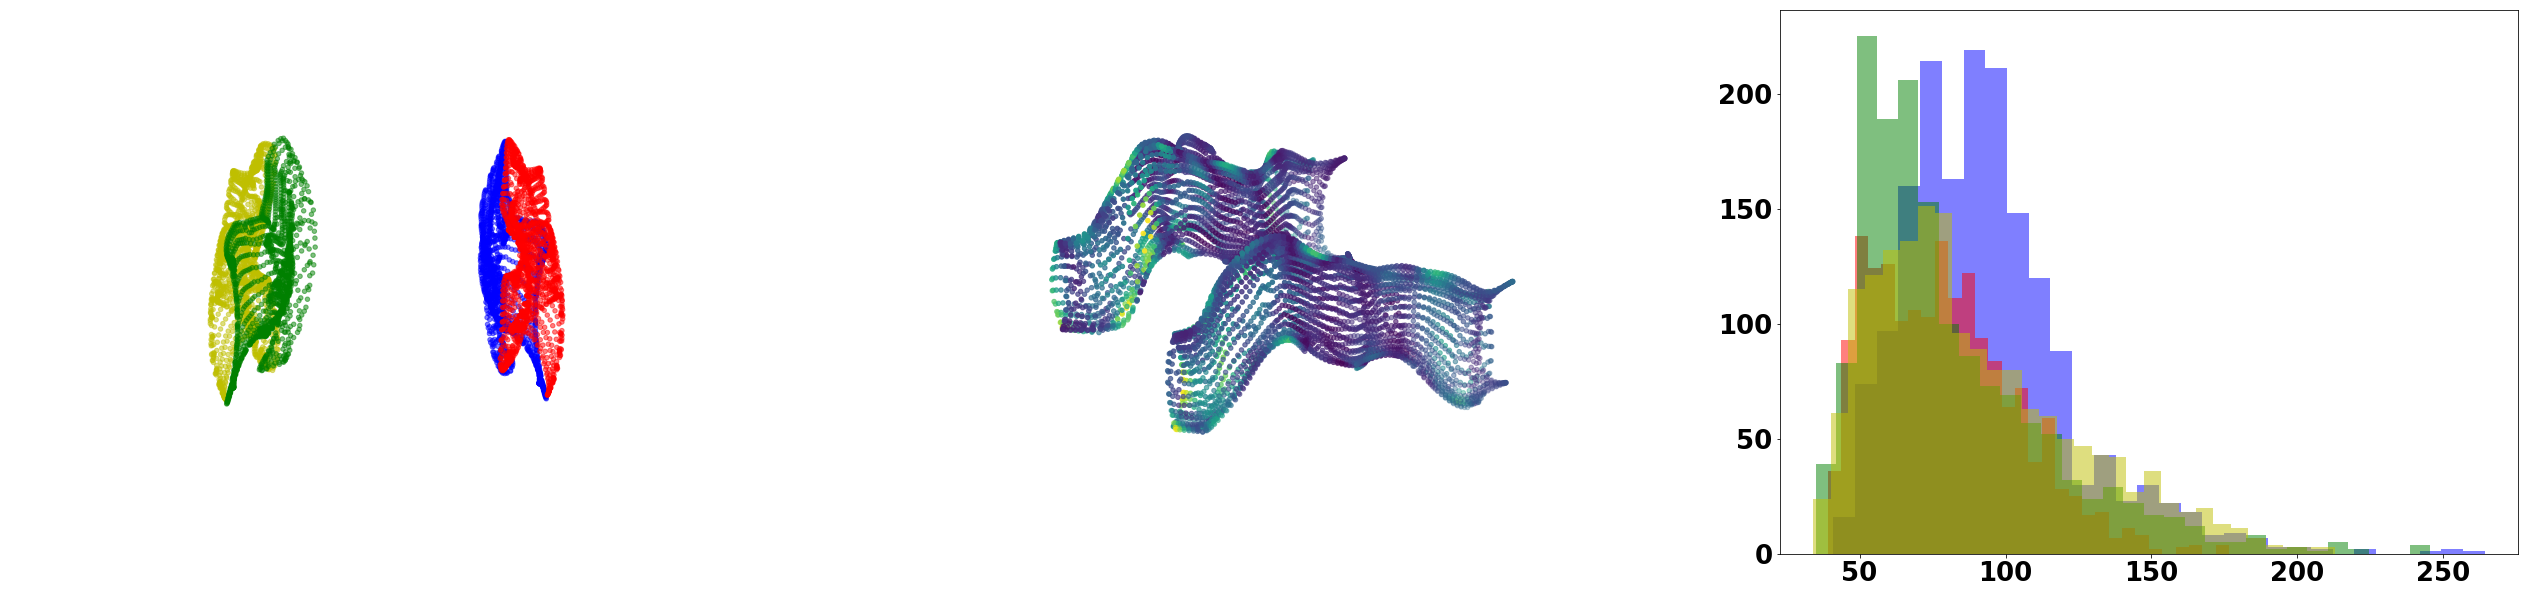

In [12]:
ch = ['b', 'r', 'g', 'y']
x_reconstructed3 = yhat[1]
    
er = []
for i in range(l, st, 1):
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(121, projection='3d')
    axx = fig.add_subplot(122)
    for p in range(P):
        db = h5py.File(namee[p], 'r')
        ds = db['Phi']
        ds = np.asarray(ds).astype(np.float32).T
        ds = ds[:, 0:d]
        ds[np.isnan(ds)] = 0.0
        ds[np.isinf(ds)] = 0.0
        cl = np.zeros((DIMM[p]))
        lxyz = np.array([[LX[p], 0, 0],
                         [0, LY[p], 0],
                         [0, 0, LZ[p]]])
        for j in range(dim):
            xyz3 = np.dot(DATAall[p][j*st+i], np.linalg.pinv(ds))
            dummy = x_reconstructed3[P*j+p, i-l].reshape((3, d))
            xyz_reconstructed3 = np.dot(pol[p]*np.dot(lxyz, dummy), np.linalg.pinv(ds))
            cl += np.linalg.norm(np.abs(xyz3 - xyz_reconstructed3), axis=0)/dim
        #cl = (cl-np.amin(cl))/(np.amax(cl)-np.amin(cl))
        if i == l:
            er.append(cl)
        else:
            er[p] += cl          
        c = ['b', 'r']
        m = ['o', 'o']
        xyz3 = np.dot(DATAall[p][0], np.linalg.pinv(ds))
        ax.scatter(xyz3[0], xyz3[1], xyz3[2], c=cl, marker=m[1]); ax.set_axis_off()
        axx.hist(cl, bins=30, color=ch[p], alpha=0.5);
    ax.view_init(40, 60)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
fig = plt.figure(figsize=(45, 10))
axx = fig.add_subplot(131, projection='3d')
ax = fig.add_subplot(132, projection='3d')
axxx = fig.add_subplot(133) 
for p in range(P):
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    xyz3 = np.dot(DATAall[p][0], np.linalg.pinv(ds))
    ax.scatter(xyz3[0], xyz3[1], xyz3[2], c=er[p], marker=m[1]); ax.set_axis_off()
    axx.scatter(xyz3[0], xyz3[1], xyz3[2], c=ch[p], marker=m[1], alpha=0.5); axx.set_axis_off()
    axxx.hist(er[p], bins=30, color=ch[p], alpha=0.5)
ax.view_init(40, 60)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
axx.view_init(0, 0)
axx.set_xlabel('x')
axx.set_ylabel('y')
axx.set_zlabel('z')     